# Case Study: Prescriptions vs Health Status

1.	Defining a Patient’s Health Status. Ideally, your characterization would be useful for establishing something like “Patient 0123 has anemia and skin infection.”

2.	Predicting Heath Status using Prescription Data alone. 

## EDA

- [Load data sets](#e1)
- [Explore data sets](#e2)
- [Understand the patient cohort](#e3)
- [Diagnosis and prescription dates](#e4)
- [Analyze diagnoses in terms of ICD10 codes](#e5)

### Defining health status

- [From diagnosis codes to defining health status](#q1a)
- [Observing patients and diagnoses as temporal sequences](#q1b)
- [Sequencing diagnosis data](#q1c)
- [Diagnosis sequence, disease progression and health status](#q1d)
- [Using primary diagnoses (plural) characterize health status](#q1e)
  - Identifying most important diagnoses using TF-IDF measure as an example

### Predicting health status using prescriptions

- [Analyzing prescription data](#q2a)
- [Encoding prescriptions](#q2b)
- [Sequencing prescriptios (Optional)](#q2c)
- [Identifying important prescriptions (Optional)](#q2d)
- [Using (temporally-aligned) prescriptions to predict health status](#q2e)
- [Model formulation](#q2f)
  - Matching prescriptions with diagnoses via temporal alignment
- [Creating training examples](#q2g)
- [Model training and evaluation](#q2h)
- [Other potential methods](#q2i)



### Import libraries

In [3]:
import sys, os
import re  
import collections
import numpy as np
import pandas as pd 
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator # used to force yticks to assume integer values
plt.style.use('ggplot')

# user-defined libraries
# import utils
from data_pipeline import load_data, fraction_rows_missing
import feature_extractor as fext

# Import relevant libraries, classes and utilty functions
from utils import * # length_of_history, time_window, transform_diagnosis, etc. 
from utils import Diagnosis, Treatment
from icd_utils import encode, decode, is_disease_specific, is_valid_icd

# set random state seed for reproducibility 
np.random.seed(53)

print(f"The following analysis was performed under:\n- Python v{sys.version}\n\n- Pandas version {pd.__version__}")
print(f"\n- Numpy version: {np.__version__}")
# print(f"Detailed system versioning of the development stack:\n{pd.show_versions()}")

The following analysis was performed under:
- Python v3.7.1 (default, Dec 14 2018, 13:28:58) 
[Clang 4.0.1 (tags/RELEASE_401/final)]

- Pandas version 1.2.0

- Numpy version: 1.19.2


<a name="e1"></a>
## Load data sets
- All the data processing functions are organized in the module `data_pipeline`
- We could choose to load the entire dataset -- or only a subset of the data for the ease of prototyping and testing 
  - When subsetting the patient data from the diagnosis and treatment table, it's convenient as a default to subset only patients (Patient_id) that appear in both tables. Later on, when predicting the health status by prescriptions, we want to ensure that each patient has (some) records in both table for the purpose of training statistical models.
  - It's important to always check missing values (this can be achieved via `fraction_rows_missing`)

In [4]:
# from data_pipeline import load_data, fraction_rows_missing

# data sets: Diagnosis.csv Prescriptions.csv  ccs.csv
input_dir = os.getcwd()
diagnosis_file = "Diagnosis.csv"
treatment_file = "Prescriptions.csv"
resource_file = "ccs.csv"
diagnosis_path = os.path.join(input_dir, diagnosis_file)  
treatment_path = os.path.join(input_dir, treatment_file) 
resource_path = os.path.join(input_dir, resource_file) 
col_key = 'Patient_id'
col_date = 'Diag_date'
col_code = 'ICD10'

n_samples = 1000

print("> Load a subset of the patient data ...") # by default, only those that appear in both diagnosis and treatment tables)
df_diag, df_treat, df_res = load_data(input_dir=os.getcwd(), n=n_samples, dropna=False, verbose=False)
assert len(df_diag[col_key].unique()) == n_samples
assert set(df_treat[col_key].unique()) == set(df_diag[col_key].unique())
print(f"> Num of patients in diagnosis table: {len(df_diag[col_key].unique())}")

print()
print("> Load the entire data set ...")
df_diag, df_treat, df_res = load_data(input_dir=os.getcwd(), subset=False, dropna=False, verbose=True)
print(f"> Num of patients in diagnosis table: {len(df_diag[col_key].unique())}")
print(f"> Num of patients in treatment table: {len(df_treat[col_key].unique())}")

> Load a subset of the patient data ...
> Num of patients in diagnosis table: 1000

> Load the entire data set ...
> size of diagnosis table: 660092
> size of treatment table: 1024029
> size of ccs lookup     : 72167
> Num of patients in diagnosis table: 84059
> Num of patients in treatment table: 82546


<a name="e2"></a>
## Explore data sets
    - Examine each patient attribute using appropriate visualization methods
    - Answer a few patient-specific queries to better understand the data

In [5]:
df_diag, df_treat, df_res = load_data(input_dir=os.getcwd(), subset=False, dropna=False, verbose=True)
Nd0, Nt0, Nr0 = df_diag.shape[0], df_treat.shape[0], df_res.shape[0]
print()

# Check missing values 
r_missing = fraction_rows_missing(df_diag, verbose=True)
print(f"> Ratio of rows with nulls in diagnosis: {r_missing:.3g}, N={int(r_missing * Nd0)}") # 9.09e-06
r_missing = fraction_rows_missing(df_treat, verbose=True)
print(f"> Ratio of rows with nulls in treatment table: {r_missing:.3g}, N={int(r_missing * Nt0)}") # 0 
r_missing = fraction_rows_missing(df_res, verbose=True)
print(f"> Ratio of rows with nulls in CCS table: {r_missing:.3g}, N={int(r_missing * Nt0)}") # 0 

print()

# Now load only rows without missing values (this is a default behavior)
df_diag, df_treat, df_res = load_data(input_dir=os.getcwd(), verbose=True)
r_missing = fraction_rows_missing(df_treat, verbose=True)

# only diagnosis table has missing values
for name, df in [('diagnosis', df_diag), ('treatment', df_treat), ('CCS', df_res), ]:
    assert fraction_rows_missing(df) == 0, \
        "Found missing values in {} table. R(missing)={}".format(name, r_missing)

print(f"> Sample size drops from {Nd0} to {df_diag.shape[0]}")

> size of diagnosis table: 660092
> size of treatment table: 1024029
> size of ccs lookup     : 72167

(fraction_rows_missing) Rows with nulls (n=6):
Patient_id Diag_date    ICD10
    P02662       NaN    Z04.1
    P11855       NaN   Z12.11
    P13678       NaN  L03.818
    P24482       NaN    K76.0
    P27885       NaN  M05.731
    P58187       NaN T78.1XXA

> Ratio of rows with nulls in diagnosis: 9.09e-06, N=6
> Ratio of rows with nulls in treatment table: 0, N=0
> Ratio of rows with nulls in CCS table: 0, N=0

> size(df_diag): 660092 -> 660086; dropped 6 rows
> size(df_treat): 1024029 -> 1024029; dropped 0 rows
> size of diagnosis table: 660086
> size of treatment table: 1024029
> size of ccs lookup     : 72167
> Sample size drops from 660092 to 660086


In [6]:
df_diag.sample(n=5)

,Patient_id,Diag_date,ICD10
39935,P06014,2018-03-30,M25.569
50168,P07441,2018-03-22,Z96.1
353643,P53291,2017-08-22,S51.851A
245448,P36622,2017-10-28,I10
185858,P27611,2016-04-04,I10


In [7]:
# Check missing data 
# r_missing = fraction_rows_missing(df_treat)
# assert r_missing == 0, "Found missing values. R(missing)={}".format(r_missing)

df_treat.sample(n=10)

,Patient_id,Prescription_date,drug_category,drug_group,drug_class,drug_code
370570,P44710,2016-08-19,Calcium Channel Blockers,Calcium Channel Blockers,Calcium Channel Blockers,D-183
183549,P12356,2015-02-17,Anticonvulsants,Anticonvulsants - Misc.,Anticonvulsants - Misc.,D-69
224226,P61683,2018-05-14,Antineoplastics and Adjunctive Therapies,Antimetabolites,Antimetabolites,D-92
872159,P47530,2016-10-09,Antidepressants,Serotonin Modulators,Serotonin Modulators,D-523
79821,P22844,2016-12-26,Adhd/Anti-narcolepsy/Anti-obesity/Anorexiants,Amphetamines,Amphetamine Mixtures,D-27
143705,P73970,2016-10-12,Antihypertensives,Antiadrenergic Antihypertensives,Antiadrenergics - Peripherally Acting,D-56
331157,P03695,2016-09-23,Ophthalmic Agents,Beta-Blockers - Ophthalmic,Beta-Blockers - Ophthalmic Combinations,D-161
799532,P16036,2015-07-28,Ulcer Drugs,Proton Pump Inhibitors,Proton Pump Inhibitors,D-489
859408,P40360,2017-05-02,Antidepressants,Selective Serotonin Reuptake Inhibitors (SSRIs),Selective Serotonin Reuptake Inhibitors (SSRIs),D-519
749622,P28485,2017-01-07,Analgesics - Opioid,Opioid Combinations,Opioid Combinations,D-432


In [8]:
# Check missing data 
# r_missing = fraction_rows_missing(df_res)
# assert r_missing == 0, "Found missing values. R(missing)={}".format(r_missing)

df_res.sample(n=5)

,diag,diag_desc,ccs_1_desc,ccs_2_desc,ccs_3_desc
59193,T458X2D,"Poisn by oth prim sys and hematolog agents, sl...",Mental Illness,Suicide and intentional self-inflicted injury ...,Suicide and intentional self-inflicted injury
699,B2701,Gammaherpesviral mononucleosis with polyneurop...,Diseases of the nervous system and sense organs,Other nervous system disorders [95.],Other nervous system disorders
32349,S4411XA,"Injury of median nerve at upper arm level, rig...",Injury and poisoning,Other injuries and conditions due to external ...,Other injuries and conditions due to external ...
27582,S270XXA,"Traumatic pneumothorax, initial encounter",Injury and poisoning,Crushing injury or internal injury [234.],Crushing injury or internal injury
5331,H018,Other specified inflammations of eyelid,Diseases of the nervous system and sense organs,Eye disorders,Inflammation; infection of eye (except that ca...


<a name="e3"></a>
### Understand the patient cohort
- Unique patients
   - Is the set of patient IDs in the treatment/prescription table a subset of those in the diagosis table? No
   - how many patients went untreated (or at least treatment not observed in the data set)?
     - Number of patients in both diagnosis and treatment: 66608
     - Approximately 80% (0.7924) of the patients in diagnosis table also have treatment data
- Statistics on diagnosis dates and treatment dates 
- Statistics on other diagnosis and treatment attributes 
   - unique ICD codes
   - any ill-formatted codes? Yes

In [9]:
col_id = 'Patient_id' 
uniq_patient_ids_diag = df_diag[col_id].unique()
uniq_patient_ids_treat = df_treat[col_id].unique()
n_uniq_pids_diag, n_uniq_pids_treat = len(uniq_patient_ids_diag), len(uniq_patient_ids_treat)
print(f"> Total unique patitent IDs in diagnosis table: {len(uniq_patient_ids_diag)}")
print(f"> Total unique patient IDs in treatment table: {len(uniq_patient_ids_treat)}")

# the set of(unique) patients in diagnosis table who also appear in treatment table
set_patients_diag_treat = list(set(uniq_patient_ids_diag).intersection(uniq_patient_ids_treat))
print(f"> n(overlap): {len(set_patients_diag_treat)}, ratio wrt diag: {len(set_patients_diag_treat)/n_uniq_pids_diag}")

# For those who were treated, can we identify all of them in the diagnosis table? 
is_treated_found_in_diag = set(uniq_patient_ids_treat) <= set(uniq_patient_ids_diag)
print(f"> PatientIDs in treatment is a subset of those in diagnosis? {'Yes' if is_treated_found_in_diag else 'No'}")

# Some patients with diagnoses did not get treated (or at least not recorded in the treatment table)
patients_diagnosed_untreated = set(uniq_patient_ids_diag) - set(uniq_patient_ids_treat)
print(f"> Num of patients diagnosed but untreated: {len(patients_diagnosed_untreated)}")

patients_diagnosed_undiagnosed = set(uniq_patient_ids_treat) - set(uniq_patient_ids_diag)
print(f"> Num of patients treated but undiagnosed: {len(patients_diagnosed_undiagnosed)}")


> Total unique patitent IDs in diagnosis table: 84059
> Total unique patient IDs in treatment table: 82546
> n(overlap): 66608, ratio wrt diag: 0.7923958172236167
> PatientIDs in treatment is a subset of those in diagnosis? No
> Num of patients diagnosed but untreated: 17451
> Num of patients treated but undiagnosed: 15938


<a name="e4"></a>
### Now, let's look at the date attributes: `Diag_date` and `Prescription_date`
  - A reasonable assumption is that a treatment generally comes after (some) diagnoses, but does it hold true in this dataset?
  - We'll begin by defining some useful utility functions

  
### Observe the relationship between patients and their first diagnois dates vs treatment/prescription dates

The relationship between the diagnosis date and the prescription date will be important later on when we try to predict health status (or disease states) via prescriptions; in particular, we may want to ensure that we only use __relevant prescriptions to predict a particular diagnosis__
  - How do we sort out the prescription relevancy? The answer is **temporal alignment**. Assuming that prescriptions are given to treat one or more diseases as represented by one or more ICD10 codes, then for each ICD10 and its diagnosis date (d), we can define the time window W centered on d, such that the W encloses d and is not too "wide." 
    - In a typical healthcare process, a prescription drug could be given prior to a diagnosis, say 60 days (e.g. the patient already had the health issue prior to the visit); on the other hand, prescription drugs are usually given following a diagnosis up to say 30 days and then the patient has to do a follow-up visit in order to get another set of prescriptions

#### Definition: Temporal Alignment

Denote a prescription by *p* and a diagnosis by *d*. Further let the date of a prescription be given by *t(p)* and the diagnosis date given by *t(d)*. Then, a prescription (p) is temporally aligned with a diagnosis (d) with respect to a time window *W = \[w1, w2\]* iff t(p) >= t(d)-w1 and t(p) <= t(d)+w2 (i.e. t(p) falls within the interval W)
- I am abusing the notation. *t(d)* can be viewed as function of *d*, or simply t subscript d

- Using the observation given above, we can then set W = (60, 60), which allows us to focus only on the prescriptions as early as 60 days prior to the **target diagnosis** and as late as 60 days following the diagnosis.
  - Certainly, the best interval depends both on the clinical condition and the treatment

#### Observations
- As can be seen from the example J06.9 (Acute upper respiratory infection, unspecified), we can find a subset of patients (approximately ~119 out of the 1500 patients) who had prescriptions matching the diagnosis given by W = (60, 60)

In [10]:
# from utils import match
from data_pipeline import intersection

dp = Diagnosis.properties
col_key = dp['id']
col_date = dp['date']
col_code = dp['code']

tp = Treatment.properties
col_date_t = tp['date']
col_class_t = tp['class']  # drug class
col_code_t = tp['code']

n_samples = 1500
# Get diagnosis and treatment table (subsampling if n_samples is given)
########################################################
df_diag, df_treat, df_res = load_data(input_dir=os.getcwd(), n=n_samples, verbose=True)
if n_samples is None:  # need to ensure that we take only patients that appear in both tables
    set_patients = intersection(df_diag, df_treat, on='Patient_id') 
    n_samples = len(set_patients)
    df_diag = df_diag[df_diag[col_key].isin(set_patients)]
    df_treat = df_treat[df_treat[col_key].isin(set_patients)]
else: 
    # if n_samples is not None, it's guaranteed that patients in set_patients appear in both table
    set_patients = df_diag[col_key].unique() 

N_diag = len(df_diag[col_key].unique()) 
N_treat = len(df_treat[col_key].unique()) 
assert N_diag == len(set_patients) <= n_samples, f"N_diag: {N_diag} =?= {len(set_patients)} <=? {n_samples}"
assert N_treat == len(set_patients) <= n_samples, f"N_treat: {N_treat} =?= {len(set_patients)} <=? {n_samples}"
########################################################

is_prescription_encoded = col_code_t in df_treat.columns
# print(f"> col(df_treat): {df_treat.columns}")

target_codes = ['J06.9', ]
W = (60, 60)  # select a window 
for target_code in target_codes: 
    df_match = match(df_diag, df_treat, target_code, window=W, verbose=1)

    # pick a random n patients and observe their respective diagnosis and prescription dates (which should satisfy
    # the date constraints)
    n_examples = 10
    pids = np.random.choice(df_match[col_key].unique(), n_examples)
    for pid, dfi in df_match[df_match[col_key].isin(pids)].groupby(col_key): 
        print(f"> Patient ID: {pid}")
        assert not dfi.empty
        if is_prescription_encoded: 
            print(dfi[[col_date, col_date_t, col_code_t]])
        else: 
            print(dfi[[col_date, col_date_t, col_class_t]])

> size(df_diag): 660092 -> 660086; dropped 6 rows
> size(df_treat): 1024029 -> 1024029; dropped 0 rows
> size of diagnosis table: 13598
> size of treatment table: 21106
> size of ccs lookup     : 72167
(match) Total number of patients: 1500
(match) Number of patients with diagnosis J06.9: 131
(match) Number of patients who had been given prescriptions for diagnosis J06.9: 131
... n(diagnosed): 131 >=? n(treated): 131
(match) diagnosis table with the window of dates determined (W=(60, 60)):
Index(['Patient_id', 'Diag_date', 'ICD10', 'Diag_min', 'Diag_max'], dtype='object')

... sampled dataframe:
+--------------+-------------+---------+------------+------------+
| Patient_id   | Diag_date   | ICD10   | Diag_min   | Diag_max   |
|--------------+-------------+---------+------------+------------|
| P01734       | 2017-05-31  | J06.9   | 2017-04-01 | 2017-07-30 |
| P01734       | 2018-05-15  | J06.9   | 2018-03-16 | 2018-05-15 |
| P01769       | 2017-03-04  | J06.9   | 2017-01-03 | 2017-05-

/Users/pleiades/Documents/work/interview/Merck/utils.py:335: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = s.apply(lambda x: x[i])


(match) Found n=120 patients with matching prescription records
> Patient ID: P02131
     Diag_date Prescription_date drug_code
23  2018-03-28        2018-03-28     D-134
24  2018-03-28        2018-04-01     D-146
25  2018-03-28        2018-02-19     D-303
26  2018-03-28        2018-02-19     D-393
27  2018-03-28        2018-04-01     D-399
28  2018-03-28        2018-03-07     D-430
29  2018-04-01        2018-03-28     D-134
30  2018-04-01        2018-04-01     D-146
31  2018-04-01        2018-02-19     D-303
32  2018-04-01        2018-02-19     D-393
33  2018-04-01        2018-04-01     D-399
34  2018-04-01        2018-03-07     D-430
> Patient ID: P06881
     Diag_date Prescription_date drug_code
60  2016-09-04        2016-09-04      D-25
61  2016-09-04        2016-10-16     D-156
62  2016-09-04        2016-10-16     D-287
63  2016-09-04        2016-10-22     D-536
> Patient ID: P13228
      Diag_date Prescription_date drug_code
118  2017-02-14        2017-02-14     D-134
119  2017-0

#### `Patient_id` vs number of sessions in diagosis table and treatment table
- Number of sessions are defined by counting the distinct values of diagosis dates and treatment dates
- Sort patients according to the number of sessions in decending order and with the same patient ordering, find their respective numbers of treatment sessions (i.e. number of prescription dates)

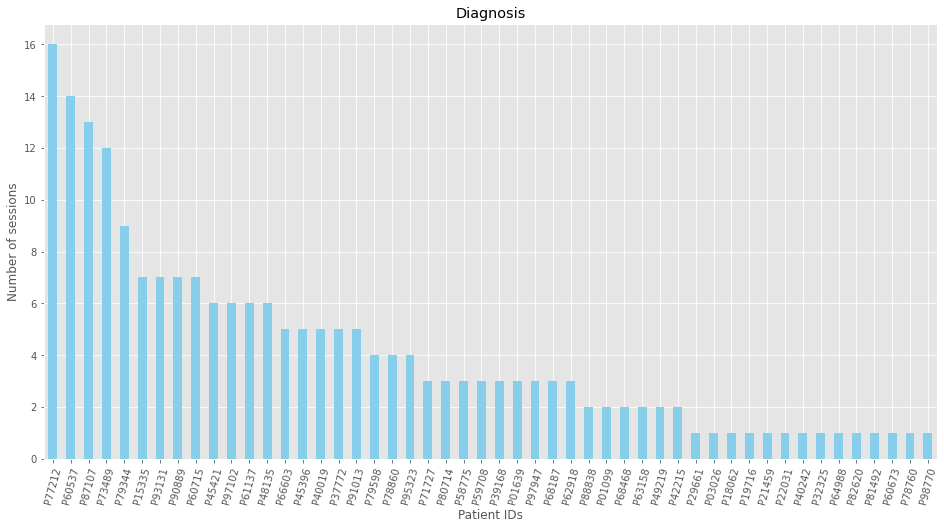

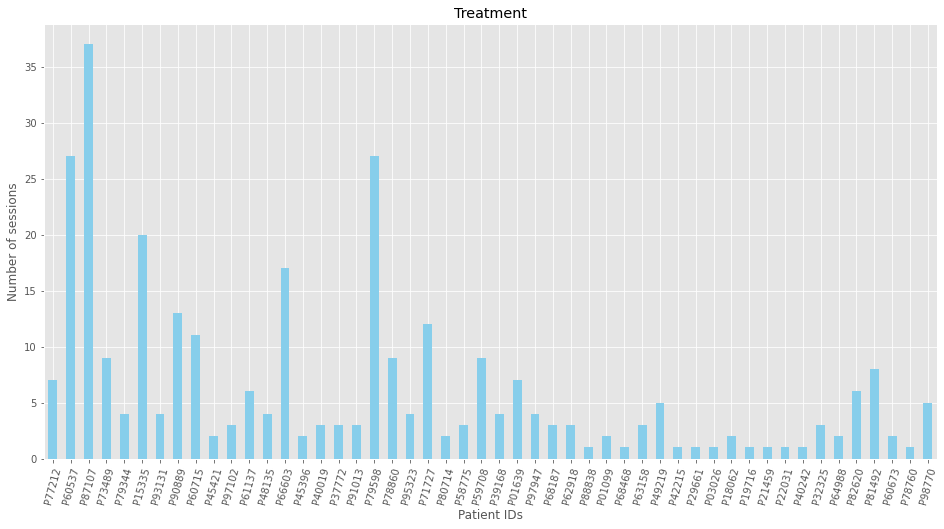

In [11]:
from plot_utils import plot_sessions

ax = plt.figure().gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True)) # force yticks to use integers

# np.random.seed(53)
df_diag_sub, df_treat_sub, _ = load_data(input_dir=os.getcwd(), n=50)
deidentify = True
pids = plot_sessions(df_diag_sub, show_key=deidentify, col='Diag_date', title='Diagnosis')

# plot patients (IDs) vs num of sessions according to the order given by the diagnosis table above
_ = plot_sessions(df_treat_sub, show_key=deidentify, col='Prescription_date', title='Treatment', pids=pids)

<a name="e5"></a>
### Analyze diagnoses in terms of ICDs across different time stamps (or sessions)  

Utilities of analyzing ICD10 codes are given the module `icd_utils`

- Below is an example EDA session to verify ICD10 codes given in the diagnosis table
  - Number of unique codes: 14257
  - Are there any ill-formatted codes? Yes, n=14
  - Number of codes not found in CCS? n=83

##### Observations  
- There are totally 83 codes not found in CCS. Let's refer to each of these codes as a "miss" for simplicity. 
  - Among these misses, a large fraction of them seem to be valid ICD10 codes; we could verify them individually and choose to keep them in the analysis. However, for the purpose of a prototype, we could also ignore them temporarily because their ratio is low.
  - Some of the misses may be ICD-9, which can be converted to ICD-10 with appropriate software. 


In [12]:
# Import relevant libraries, classes and utilty functions
from data_pipeline import analyze_diagnosis

df_diag, codebook = analyze_diagnosis(verbose=1)

(1) Number of unique codes: 14257
(2) Invalid codes (n=14):
['999.99', '999.9', '036.8130', 'KHD.X', '000', '309.28', '281', '411', '742.3', 'MHD.X', '065.5', '327.23', '167.1', '000.0']

(3) Num of codes not found in CCS (n=83):
['I83.89', 'Z12.1', 'S30.0', 'C44.5', 'S02.612', 'S93.401', 'S92.11A', 'S69.91', 'S80.211', '999.99', 'V50.9', 'K52.80', 'S92.352', '000.0', 'R20', 'Z80.401', '167.1', '742.3', 'M25.11', 'H40.113', 'S99', 'R51.67', 'T42.0', 'S83.501', 'E07.8', 'V70.0', 'N04.59', 'H10.42', 'Q33.5XX1', 'M75.12', 'I83.8', '999.9', 'N30.4', 'M97.645', 'O47.88', 'H66.3', 'M21.61', 'S83.512', '000', 'K11.2', 'Z00.0', 'O29', 'S00.06', 'H10.2', 'C47.03', 'D37.0', 'M75.11', 'B08', '065.5', 'O26.2', 'R29.70', 'S73', 'M20.1', 'N64.80', 'Z00.1', 'J45.90', 'S90.112', 'KHD.X', 'M35.0', 'R88.82', '327.23', 'V22.1', 'Z01.41', '411', 'Z48.81', 'MHD.X', 'F04.2', 'S27.00XX', 'C50.91', '281', 'S86.011', 'H40.133', 'S76.111', '309.28', 'H90.1', 'M11.16', 'F78.4', 'S00', 'S42.413', 'J45.4', '036.81

In [13]:
codes_missed = codebook['missed']
code_counts = collections.Counter(dict(df_diag[col_code].value_counts())) 

# Among all the codes that are missed by CCS, list their documentation frequencies: 
# Are they simply errors, systematic anomelies, or perhaps "valid" but not in ICD10?
for code in sorted(codes_missed, key=lambda x: code_counts[x], reverse=True)[:20]:
    code_eff = decode(code)
    assert code_eff in code_counts, "code {} not found".format(code_eff)
    print(f"> Code missed {code_eff}: {code_counts[code_eff]}") 
    

> Code missed 999.99: 591
> Code missed KHD.X: 35
> Code missed 000: 21
> Code missed S00.06: 12
> Code missed K59.0: 6
> Code missed S86.011: 4
> Code missed Z01.41: 3
> Code missed Z00.0: 2
> Code missed Z00.1: 2
> Code missed J45.90: 2
> Code missed V22.1: 2
> Code missed MHD.X: 2
> Code missed S27.00XX: 2
> Code missed 309.28: 2
> Code missed I83.89: 1
> Code missed Z12.1: 1
> Code missed S30.0: 1
> Code missed C44.5: 1
> Code missed S02.612: 1
> Code missed S93.401: 1


<a name="q1a"></a>
### From diagnosis codes to defining health status

##### Observations 
- Some of the CSS-missed codes (or simply "misses") are actually documented quite often (e.g. 999.99 has 591 mentions, where 999.99 could be an mis-coded ICD-9 code) 
- Some of the misses are legit even though they are not found in the CCS table (i.e. `df_res`)
  - e.g. J45.90: unspecified asthma 
- Some high-frequency ICD10 codes do not necessarily represent a health status per se but represent external factors (e.g. lab tests, symptoms) linked to the health status or disease state. E.g. Z00.00 (Encntr for general adult medical exam w/o abnormal findings) has over 20K mentions in the data set (`df_diag`) but __it is not a direct description of a health status and therefore by itself does not say much about a patient's clinical conditions.__
  - E.g. R05 (Cough), is a symptom
  - ICD10 codes that are alphanumerically larger than **O00** are often not disease-specific coding according to their [standard categorization](https://www.medicalbillingandcoding.org/icd-10-cm/)
 
- Some disease-specific ICD10 codes are mentioned very frequently because they are often concomitant relative to something more critical. E.g. I10 (hypertension) has 16315 mentions but it may be a comorbid condition to diabetes, CKD, etc.
   - As will be discussed shortly, we can sort the ICD10 codes according to their associated time stamps and thereby form a diagnosis-specific temporal sequence, which can give us a quick overview of how the patient's disease state progresses over time. This will serve as a basis for computing signficance of each diagnosis later on.
   - E.g. Patient (ID=*P52427*) has the diagnosis sequence *`R05 I10 J45.40 K76.0 R10.13 I10 K57.92 K57.92 K57.92 R10.30`*, where **J45.40 (asthma)** could be the primary diagnosis, for which **I10** is a correlated condition and thus tends to co-occur often with J45.40, i.e. patients with asthma are more likely to develop hypertension (see [this paper](https://www.nejm.org/doi/full/10.1056/NEJMra1800345) for more details)

In [14]:
# Example codes that are (probably) not disease-specific but relevant external factors 
# (e.g. medical procedures) linked to the patient's health conditions. 
codes_aux = ['R0609', 'Z4732', 'Z1211', 'Z23']
df_res[df_res['diag'].isin(codes_aux)]

,diag,diag_desc,ccs_1_desc,ccs_2_desc,ccs_3_desc
22550,R0609,Other forms of dyspnea,Diseases of the respiratory system,Other lower respiratory disease [133.],Other lower respiratory disease
71018,Z1211,Encounter for screening for malignant neoplasm...,Symptoms; signs; and ill-defined conditions an...,Factors influencing health care,Other screening for suspected conditions (not ...
71141,Z23,Encounter for immunization,Infectious and parasitic diseases,Immunizations and screening for infectious dis...,Immunizations and screening for infectious dis...
71408,Z4732,Aftercare following explantation of hip joint ...,Symptoms; signs; and ill-defined conditions an...,Factors influencing health care,Other aftercare


In [15]:
# Example codes that are likely to be comorbid conditions (rather than the main diagnosis)
_, _, df_res = load_data(input_dir=os.getcwd(), subset=False, verbose=0)
codes_secondary = ['I10', 'M542']
df_res[df_res['diag'].isin(codes_secondary)]

,diag,diag_desc,ccs_1_desc,ccs_2_desc,ccs_3_desc
8532,I10,Essential (primary) hypertension,Diseases of the circulatory system,Hypertension,Essential hypertension
14772,M542,Cervicalgia,Diseases of the musculoskeletal system and con...,Spondylosis; intervertebral disc disorders; ot...,Spondylosis; intervertebral disc disorders; ot...


In [16]:
# top 10 diagnosis codes
codes_valid = codebook['valid'] # set(codes) - set(codes_invalid)
codes_disease = codebook['disease']
print(f"> Found {len(codes_valid)} valid ICD10 codes.")
print(f"> Found {len(codes_disease)} disease-specific codes (ratio: {len(codes_disease)/len(codes_valid)})")
print(f"> examples:\n{list(codes_valid)[:10]}\n")
print()

topn = 15
print(f"> 1. Most popular diagnosis codes ...") # remember to call encode() before table lookup!!! 
for code in sorted(codes_valid, key=lambda x: code_counts[x], reverse=True)[:topn]: 
    print(f"> {code} (freq={code_counts[code]}): {df_res[df_res['diag']==encode(code)]['diag_desc'].values}")

print()
print(f"> 2. Most popular disease-specific diagnosis codes ...")
for code in sorted(codes_disease, key=lambda x: code_counts[x], reverse=True)[:topn]: 
    print(f"> {code} (freq={code_counts[code]}): {df_res[df_res['diag']==encode(code)]['diag_desc'].values}")
    
# Among all the patients with I10 (hypertension), can we find 
# a reasonable primary diagnosis for which hypertension could be just a concomitant condition (e.g. CKD, diabetes)? 
print()
codes_secondary = ['I10', 'M54.2']
n_samples = 5
pids = df_diag[df_diag[col_code].isin(codes_secondary)][col_key].unique()
pids = np.random.choice(pids, min(n_samples, len(pids)))
df_seq = transform_diagnosis(df_diag[df_diag[col_key].isin(pids)])
col_key, col_date, col_code, *_ = df_diag.columns
col_intv = 'History'
for pid, row in df_seq.iterrows(): 
    print(f"> ID:      {row[col_key]}")
    print(f"> history: {row[col_intv]} days")
    print(f"> sequence:\n{row[col_code]}\n")
    

> Found 14243 valid ICD10 codes.
> Found 7852 disease-specific codes (ratio: 0.5512883521729972)
> examples:
['C81.74', 'M71.579', 'N44.1', 'T43.011A', 'N82.3', 'G91.0', 'T45.1X5D', 'D80.2', 'T38.4X5S', 'F40.11']


> 1. Most popular diagnosis codes ...
> Z00.00 (freq=23987): ['Encntr for general adult medical exam w/o abnormal findings']
> I10 (freq=16315): ['Essential (primary) hypertension']
> Z01.419 (freq=12624): ['Encntr for gyn exam (general) (routine) w/o abn findings']
> Z12.31 (freq=8870): ['Encntr screen mammogram for malignant neoplasm of breast']
> M54.5 (freq=8410): ['Low back pain']
> Z00.129 (freq=7805): ['Encntr for routine child health exam w/o abnormal findings']
> J06.9 (freq=7766): ['Acute upper respiratory infection, unspecified']
> Z23 (freq=6889): ['Encounter for immunization']
> J02.9 (freq=6174): ['Acute pharyngitis, unspecified']
> E11.9 (freq=6043): ['Type 2 diabetes mellitus without complications']
> R05 (freq=5567): ['Cough']
> R07.9 (freq=4361): ['Chest pa

<a name="q1b"></a>
### Observing patients and their diagnoses as temporal sequences
- How long are their medical histories? 
- List all the diagnoses and their dates from the first session to the last

#### Observations
- The longest medical history is 1339 days long
- (Most) patients tend to have very different diagnoses at different times throughout their medical history. To characterize a patient's health status or disease state, we would want to focus on: 
   - 1) Recency or temporal locality (e.g. most recent 180 days): Adjustable depending on the chronicity of the disease. 
   - 2) The degree of importance for a given diagnosis (as proxy-represented by one or more ICD10 codes): In particular, the **"importance weight"** of an ICD code is related to their **recency**, **frequency** and **specificity** for an individual's disease state. Assuming that the recency is already being qualified by 1), we can determine the importance weight of an ICD10 code by **some function of a ICD10's documentation frequency** -- and how "special" this diagnosis is to a particular patient. Why? 
      - Two patients X and Y may share similar overall diagnoses (e.g. they both have hypertension, or I10, frequently occurred in their records); however, their primary diagnoses may be quite different. E.g. X could be a patient with CKD as the main health issue, whereas Y has been a long-term type 2 diabetes patient, both are at higher risk of experiencing hypertension episodes or even cardiovascular conditions. 
   - 3) As mentioned earlier, some ICD codes are not directly indicative of a health status while others may be comorbid conditions (i.e. not primary diagnoses to be informative for defining health status).
       
Note that the aforementioned criteria (i.e. temperal locality and frequency) are just an approximation to the patient's true disease state. The "true" disease state is actually a __time series__ and therefore it changes over time. 

To consider a more precise characterization of a patient's health status, we can also consider the temporal sequence of ICD10 codes obtained from the most recent medical history (e.g. codes assigned during the past 180 days) as an even better approximation for a patient's disease state, given that the ordering of diagnoses could serve as a __proxy representation for disease progression__. 

As can be observed from the data, most patients tend to have more than one ICD10 code documented in their records, which could be **i) a recurrent health condition ii) the same condition with a different severity stage (hence a different ICD code) iii) comorbid conditions for a primary diagnosis -- or iv) simply a new diagnosis reflecting a new episode of pathologically different heath condition than those from the past. Any new ICD assignment may or may not be relevant to his/her old conditions.** 
- E.g. Among those patients with COPD (J44.9), we could very well observe multiple other diagnosis codes (that tend to co-occur with the primary diagnosis) such as i) J42 (unspecified chronic bronchitis) as a comorbid condition ii) tobacco use (Z72.0), as a another external factor that would affect the health status ... //this is my own example, not what's being observed in this data set

Not all diagnosis codes represent diseases but they can be symptoms, abnormal lab findgs, injuries, and other factors that affect health status but nonetheless, they do not represent "heatlh status" by themselves. 

In [ ]:
from utils import demo_sequencing, subsample_seq
from IPython.display import clear_output

sample_size = 1000
df_seq = demo_sequencing(dtype='diag', verbose=1)

print()
df_diag, df_treat, df_res = load_data(input_dir=os.getcwd(), subset=False, verbose=False)
pids_anomely = ['P00021', ]
for r, row in df_diag[df_diag[col_key].isin(pids_anomely)].iterrows(): 
    print(row)
# clear_output(wait=False)

<a name="q1c"></a>
### Sequencing diagnosis and loading sequenced data

In [ ]:
from utils import subsample_seq

df_diag = Diagnosis.load(dtype='in', subset=False, verbose=0)
Np = len(df_diag[col_key].unique())
tLoad = True

diag = Diagnosis() # create a Diagnosis object
if tLoad: 
    df_seq = Diagnosis.load(dtype='seq') # load the pre-computed sequence data, because it's take a minute or two to sequence the data
else: 
    diag.init(**kargs) # ensure that 'diag' is hooked to the diagnosis table
    df_seq = diag.sequence(tFilterByICD=True, tFilterByLength=True, n_days_lookback=180)
    # note: set tFilterByICD to True to only include valid (well-formatted) ICD10 codes
    #       set tFilterByLength to False to include the entire d-sequence for each patient
    #       Say you want to focus on only the most recent 100 days of diagnoses, then pass 
    #       n_days_lookback=100
    
Ns = len(df_seq[col_key].unique())
print(f"Number of (unique) patients in original data: {Np}, in sequenced file: {Ns} | {Np} >=? {Ns}")
print(f"Longest length of medical records (days): {df_seq[col_intv].max()}")

print(f"\nShow example d-sequences ...")
subsample_seq(df_seq, n=10, verbose=True)

<a name="q1d"></a>
### Diagonsis sequence, disease progression and health status 
- Since each patient can have a long medical history, which equates to a long time series of diagnosis. The diagonsis sequence sheds light on how a disease progresses over time and thereby defining health status, which is time-varying.
- We can simplify the representation of the diagnosis time series by representing them as a temporally ordered sequence of diagnosis codes like so: `L57.8 M25.512 S43.085A S43.085A S43.085A S43.085A S43.085A S43.085A`
- To distinguish between primary and secondary diagnoses as pertaining to comorbid conditions, domain knowledge is often required but we could apply simple heurstics to tease out the main diagnoses
  
- We will use TF-IDF as an example measure of diagnostic importance via the following steps: 
  - First, we represent each patient in terms of a temporally-ordered diagnostic sequence, which we will refer to as simply -- diagnositic sequence, or d-sequence. 
  - Treat each d-sequence as a (patient) document
  - Compute a TF-IDF score for each ICD10 associated with a d-sequence
    - Intuitively, ICD10 codes that occur frequently in a d-sequence are important because they have high "term frequencies (TFs)" 
    - However, the ICD10 codes that are individually important for a patient should be clinically more important than those that tend to occur in different patients' diagnoses (common comorbid conditions, seasonal flu, etc.); this is measured by ICD10's inverse document frequencies (IDFs)

<a name="q1e"></a>
### Using the primary diagnoses (plural) to characterize health status
- We could pick the top-n ICD codes with the highest importance score (e.g. TF-IDF score) as the primary diagnoses
  - Note that this should be considered as **an approximation to a patient's true health status** (although diagnosis codes themselves are merely a proxy to a patient's health status because they are not always accurate)
  - D-sequence contains more information about a patient's health status but in order to use prescriptions to predict health status, d-sequence is not as simple to model as a "label." 
  - Later on, by representing prescriptions as temperal sequences like a d-sequence, it's also possible to apply sequence models (e.g. seq2seq, Siamese networks) to predict the health status encoded by d-sequences; however, in this prototype, we shall consider simpler methods

#### Representing patients by their d-sequences
- As mentioned before, recency is an important factor for qualifying a patient's health status; from the EDA, we know that the longest medical history in this dataset is over 3 years (1300+ days), which is perhaps too long to be factored in a patient's health status.  
- In the following demo, we shall consider the **truncated d-sequence** for each patient (180 days), out of which we then compute the importance score for each ICD code. 
  - Alternatively, pass different values to `n_days_lookback` parameter (as an argument for `Diagnosis.sequence()`) to truncate the older segment of the d-sequence at varying degrees. For instance, if you want to focus on only the most recent 60 days of diagnoses, then specify `n_days_lookback=60` also in `Diagnosis.sequence()`. Patients with predominently acute conditions would be good use cases for a more restrictive constraint. 
  - Diagnosis dates are lost in d-sequence by default (only the ordering is preserved). If you wish to include time stamps in the d-sequence, please set `tIncludeTime` to True. 
  - The `History` attribute in the resulting d-sequence dataframe (`df_seq`) is measured in **days**. 

#### Estimating the most important diagnoses
- Compute the top-n most important diagnoses according to a given measure (e.g. TF-IDF) 
- We'll apply TF-IDF on d-sequences as a measure of importance
  - The top-n ICD10 codes, where n=3 in the following demo, are considered as the most representative diagonses that collectively describe a patient's health status

In [17]:
from utils import demo_topn_diagnoses
demo_topn_diagnoses(topn=20)

[Diagnosis] Loading sequenced diagnosis file from:
/Users/pleiades/Documents/work/interview/Merck/Diagnosis-sequenced.csv

(eval_topn_features) Nd: 84051, dim(Xtr): (84051, 11863), size(vocab): 11863
... example feature names (n=11863=?=11863):
['A02.0', 'A03.8', 'A04.0', 'A04.1', 'A04.4', 'A04.5', 'A04.7', 'A04.71', 'A04.72', 'A04.8', 'A04.9', 'A05.8', 'A05.9', 'A06.0', 'A06.9', 'A07.1', 'A07.3', 'A07.8', 'A08.0', 'A08.11', 'A08.19', 'A08.2', 'A08.39', 'A08.4', 'A08.8', 'A09', 'A15.0', 'A15.6', 'A15.7', 'A15.9', 'A150', 'A17.81', 'A18.4', 'A26.0', 'A28.1', 'A31.0', 'A31.9', 'A35', 'A37.00', 'A37.90', 'A38.8', 'A38.9', 'A40.1', 'A40.8', 'A40.9', 'A41.01', 'A41.02', 'A41.1', 'A41.50', 'A41.51']
['Z95.4', 'Z95.5', 'Z95.810', 'Z95.811', 'Z95.818', 'Z95.820', 'Z95.828', 'Z95.9', 'Z96.0', 'Z96.1', 'Z96.22', 'Z96.41', 'Z96.5', 'Z96.60', 'Z96.611', 'Z96.612', 'Z96.622', 'Z96.641', 'Z96.642', 'Z96.643', 'Z96.649', 'Z96.651', 'Z96.652', 'Z96.653', 'Z96.659', 'Z96.7', 'Z96.81', 'Z96.9', 'Z97.10'

(       code  count                                          code_desc
 15      I10   3766                   Essential (primary) hypertension
 24    J06.9   2795     Acute upper respiratory infection, unspecified
 33    J02.9   2257                     Acute pharyngitis, unspecified
 18    E11.9   1446     Type 2 diabetes mellitus without complications
 91    M54.5   1282                                      Low back pain
 73   J01.90   1252                       Acute sinusitis, unspecified
 136   J20.9   1076                      Acute bronchitis, unspecified
 108   E78.5   1041                        Hyperlipidemia, unspecified
 47    N39.0    954        Urinary tract infection, site not specified
 156   E03.9    887                        Hypothyroidism, unspecified
 102   L70.0    883                                      Acne vulgaris
 344  E11.65    784        Type 2 diabetes mellitus with hyperglycemia
 25    E78.2    732                               Mixed hyperlipidemia
 332  

<a name="q2a"></a>
### Analyzing prescription data
- There are 604 drug classes, 415 drug groups and 89 drug categories. 
- Similar to how the diagnosis progression can be captured by the *d-sequence*, we can also define the prescription sequence (or treatment pathway) as the __temporally ordered sequence of prescriptions (or simply denoted as the p-sequence)__. 
  - The analysis for the treatment/prescription data is similar to the diagnosis table give earlier except that drugs are not coded like ICD10 for diagnosis. 
  - For the ease of analysis and modeling, we will encode the prescription based on the drug attribute with the most specificity, which is the `drug_class` (|drug_class|=604)
  - Given this, we can then define prescription sequence (or *p-sequence*) as the temporally ordered drug codes. 

- To determine the most important prescription drugs for each patient, we can again apply TF-IDF over the p-sequences to heuristically determine the importance weight for each drug prescription in each patient historical record.
  - Doing so could help us potentially reduce the number of prescription variables when building statistical models to predict the health status. 
  - It's helpful sometimes to consider reducing the number of variables because we may not have sufficient sample sizes in some cases to train a reasonably accurate model with 604 variables.
  
- For the purpose of this demo, I'll build baseline models (e.g. logistic regression) for a few ICD10 codes (n=10) selected from the most common primary diagnoses, where 'primary' is defined by couting from within the top-n ICD10 codes (n=3) used to represent the health status for each patient. See `utils.demo_topn_diagnoses()` for more details.
  - In this demo, I will not choose non-disease-specific ICD10 codes (i.e. most ICD10 codes alphanumerically greater than O00) as targets; intuitively, prescriptions are more correlated to disease-related diagnoses rather than, say, lab tests and misc medical procedures but of course, this hypothesis needs to be verified.
  - But in general, we could build a predictive model for all primary diagnoses. 
  - We can then observe the predictive performances (in F1 score) in these cases.


In [1]:
from data_pipeline import analyze_treatment 
analyze_treatment()

(1.1) Found n=89 drug categories, and their counts are as follows:
Antidepressants                                  92834
Antihypertensives                                62022
Antihyperlipidemics                              58264
Contraceptives                                   51732
Antidiabetics                                    49251
Dermatologicals                                  40185
Anticonvulsants                                  37644
Analgesics - Opioid                              34163
Thyroid Agents                                   31785
Antiasthmatic and Bronchodilator Agents          30977
Analgesics - Anti-Inflammatory                   29641
Adhd/Anti-narcolepsy/Anti-obesity/Anorexiants    28434
Antianxiety Agents                               28018
Beta Blockers                                    27910
Ulcer Drugs                                      27055
Penicillins                                      25007
Antivirals                                       2457

(        Patient_id Prescription_date                            drug_category  \
 0           P04447        2015-07-22     Genitourinary Agents - Miscellaneous   
 1           P20764        2016-12-19     Genitourinary Agents - Miscellaneous   
 2           P34917        2016-12-17     Genitourinary Agents - Miscellaneous   
 3           P18892        2018-02-12     Genitourinary Agents - Miscellaneous   
 4           P33131        2018-02-09     Genitourinary Agents - Miscellaneous   
 ...            ...               ...                                      ...   
 1024024     P09160        2016-08-21  Antiasthmatic and Bronchodilator Agents   
 1024025     P08970        2016-07-09  Antiasthmatic and Bronchodilator Agents   
 1024026     P16202        2017-04-15  Antiasthmatic and Bronchodilator Agents   
 1024027     P06670        2016-04-21  Antiasthmatic and Bronchodilator Agents   
 1024028     P53711        2018-04-12  Antiasthmatic and Bronchodilator Agents   
 
              

<a name="q2b"></a>
### Encoding prescriptions
- Each `drug_class` is encoded with a prefix 'D' (by default), following by '-' and an index ranging from 0 to 603 (since there are 604 drug classes in total) i.e. D-0, D-1, ... , D-603

In [ ]:
from utils import demo_encode_treatment
demo_encode_treatment()

<a name="q2c"></a>
### Sequencing prescriptions 
- Generating *p-sequences* helps us identify important prescriptions
- Use TF-IDF to idenify important prescriptions for each patients

- Once we know the most import prescriptions (say top 10) for each patient, we can then take the union of top prescriptions across patients to arrive at the final set of prescriptions, which is likely smaller than the total number of prescriptions. This could help reduce the number of variables when predicting health status.
    - We'll skip this step for the purpose of this demo by using all prescriptions as variables.

#### Observations
- From the sequencing process, we find that prescription drugs can be duplicated in the same session; this is unlike the case of ICD10, for which we'd expect no duplicates in the same session

In [ ]:
# this takes some time!

from utils import demo_sequencing
demo_sequencing(dtype='treat', verbose=1)

<a name="q2d"></a>
### Find the most important drug prescriptions
- Given the p-sequences, we can then conveniently use them as inputs to the TF-IDF model to find the most important prescriptions for each patient. 
- Note that the sequenced representation is helpful as a format for training seq2seq model (i.e. using prescription sequences to predict likely diagnosis segments); however, we will not use this approach in this demo/prototype

In [2]:
from utils import demo_topn_prescriptions
demo_topn_prescriptions()

[Treatment] Loading sequenced treatment/prescriptions file from:
/Users/pleiades/Documents/work/interview/Merck/Prescriptions-sequenced.csv

(eval_topn_features) Nd: 82546, dim(Xtr): (82546, 568), size(vocab): 568
... example feature names (n=568=?=568):
['D-0', 'D-1', 'D-10', 'D-100', 'D-101', 'D-102', 'D-103', 'D-104', 'D-105', 'D-106', 'D-107', 'D-108', 'D-109', 'D-11', 'D-110', 'D-111', 'D-112', 'D-113', 'D-114', 'D-115', 'D-116', 'D-117', 'D-118', 'D-119', 'D-12', 'D-120', 'D-121', 'D-122', 'D-123', 'D-124', 'D-126', 'D-127', 'D-128', 'D-129', 'D-13', 'D-130', 'D-131', 'D-132', 'D-133', 'D-134', 'D-135', 'D-136', 'D-138', 'D-139', 'D-14', 'D-140', 'D-141', 'D-142', 'D-144', 'D-145']
['D-596', 'D-597', 'D-598', 'D-599', 'D-6', 'D-60', 'D-600', 'D-601', 'D-602', 'D-603', 'D-61', 'D-62', 'D-63', 'D-64', 'D-65', 'D-66', 'D-67', 'D-68', 'D-69', 'D-7', 'D-70', 'D-71', 'D-74', 'D-75', 'D-76', 'D-77', 'D-78', 'D-79', 'D-8', 'D-80', 'D-81', 'D-82', 'D-83', 'D-84', 'D-85', 'D-86', 'D-87', '

<a name="q2e"></a>
### Using prescriptions to predict health status
Earlier we used the __top-n primary diagnoses (subject to the contraint of recency) to characterize a patient's health status__. In the demo, we set n=3 and n_days_lookback=180 (as a reminder, this means that we only consider the d-sequences at most 180 days long counting from the most recent visit). 
  - Certainly, the *n* in top-n, *window size*, *n_days_lookback* are all considered as adjustable hyperparameters to be optimized 
- For simplicity and as a baseline method, we could formulate the health-status predictive problem by predicting a single diagnosis code one at a time. 
  - In this manner, we will then build a model for each of the primary diagnosis associated with a patient's health status 
  - However, there are n=10678 models to train (see the following cell), some of which may not even have sufficient sample sizes for a regular statistical model
  - Training a large set of models is usually not an issue, which can be put in a loop and trained off-line. But for the purpose of this demo, I'll only focus on 10 ICD10 codes selected from the most popular primary diagnoses to see if  any skills that can be learned from the data using prescriptions.
  
- I'll briefly discuss alternative formulations shortly
  

In [3]:
from utils import Diagnosis
import collections

dp = Diagnosis.properties
col_key = dp['id']
col_history = dp['history']
col_status = dp['status']

df_seq = Diagnosis.load(dtype='seq', verbose=True)
counter = collections.Counter()
for status in df_seq[col_status].values: 
    counter.update(status.split())
print(f"> Found n={len(counter)} unique primary diagnosis codes.")

[Diagnosis] Loading sequenced diagnosis file from:
/Users/pleiades/Documents/work/interview/Merck/Diagnosis-sequenced.csv

> Found n=10678 unique primary diagnosis codes.


<a name="q2f"></a>
### Model formulation

- Explanatory variables (or features): All the distinctive prescription drugs will be used as candidate explanatory variables (alternatively you could use top-n prescriptions as a screening mechanism to reduce the variable set; see module `utils`, in particular method `eval_topn_prescriptions()` of the `Treatment` class)
   - For convenience, prescription drugs are coded according to `drug_class` (D-1 ~ D-603)
   - Number of variables: 604
- Response variable (or label): In principle, all the primary diagnosis codes are potential targets; however, I'll demonstrate 10 target ICD10 codes for this demo
   - Training the model for the remaining ICD10 codes is a similar process; however, there are codes with very low sample sizes, for which we will then have to resort to either data augmentation or rule-based approach 
   - From the data augmentation perspective, we could consider training **similar ICD10 codes** aggregately as a single model (e.g. all codes with the same first 3 digits); in the interest of time, I'll not address this in this demo
   - The notion of the **temporal alignment** mentioned earlier can be thought of as a rule-based approach. It's much more likely for any prescription drugs with dates close to the diagnosis date to be relevant and predictive; therefore, when the sample size is too low, this alignment rule is a good heurstic.

#### Matching prescriptions with a given diagnosis date
- The ideal values for W is a hyperparameter to be optimized or can be given by domain experts
- The `match` operation is defined in module `utils`, which identifies all the prescription drugs that fall within the scope of a given W associated with a diagnosis date

In [4]:
from utils import demo_match

target_codes = ['J06.9', ]
W = (60, 60)
demo_match(target_codes, W, verbose=1)

(match) Total number of patients: 66608
(match) Number of patients with diagnosis J06.9: 5700
(match) Number of patients who had been given prescriptions for diagnosis J06.9: 5700
... n(diagnosed): 5700 >=? n(treated): 5700


/Users/pleiades/Documents/work/interview/Merck/utils.py:335: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = s.apply(lambda x: x[i])


(match) diagnosis table with the window of dates determined (W=(60, 60)):
Index(['Patient_id', 'Diag_date', 'ICD10', 'Diag_min', 'Diag_max'], dtype='object')

... sampled dataframe:
+--------------+-------------+---------+------------+------------+
| Patient_id   | Diag_date   | ICD10   | Diag_min   | Diag_max   |
|--------------+-------------+---------+------------+------------|
| P00014       | 2018-04-19  | J06.9   | 2018-02-18 | 2018-05-24 |
| P00037       | 2018-01-31  | J06.9   | 2017-12-02 | 2018-04-01 |
| P00054       | 2017-01-05  | J06.9   | 2016-11-06 | 2017-03-06 |
| P00054       | 2017-11-05  | J06.9   | 2017-09-06 | 2018-01-04 |
| P00056       | 2017-01-15  | J06.9   | 2016-11-16 | 2017-03-16 |
| P00075       | 2017-02-01  | J06.9   | 2016-12-03 | 2017-04-02 |
| P00075       | 2018-01-20  | J06.9   | 2017-11-21 | 2018-03-21 |
| P00096       | 2017-12-17  | J06.9   | 2017-10-18 | 2018-02-15 |
| P00109       | 2017-10-26  | J06.9   | 2017-08-27 | 2017-12-25 |
| P00117      

<a name="q2g"></a>
### Creating Training examples
- The making of training examples is a direct application of `match()` in module `utils`
- Creating positive examples for a given diagnosis (say J06.9) is straightforward; each patient constitutes a training example. Recall that we've set `n_days_lookback` = 180, which results in *d-sequences* to be at most 180 days long and within this time frame, we'll then loop through all the diagnosis dates, each of which is associated with a set of relevant prescriptions, qualified via W and the given diagnosis date (d). Note that it's possible that no prescriptions can be found at all given W and d.
- Creating negative examples is trickier and is perhaps an open question. What is the most reasonable control group for J06.9 (acute upper respiratory infection)? In principle, any diagnosis code that is not J06.9 can serve as negative examples because after all we are trying to predict 'yes' or 'no' for candidate cases of J06.9. **However**, ...
  - The set of all possible negative examples is too huge and not all of them are meaningful as part of a control group
  - If we include samples whose treatment pathways or prescription histories are too "different" than our target patients of J06.9, then very likely we will be getting a very trial model 
  - We may want to incorporate substantial amounts of "similar patients" of varing degrees so that the resulting decision boundary is robust enough to distinguish nuances of minor prescription differences
  - As a trade-off, I'll include __a mixture of both similar and different cases, as negatives, in terms of the ICD hierarchy__. For instance, when predicting positive cases of J06.9, the classifier should learn to distinguish it from codes that **look like J06 (caveat?) but not J06.9 itself** -- as well as J0x and Jxx, i.e. the set of negative examples contain those cases associated with diagnoses of potentially very similar categories. 
    - I put a question mark in the first scenario because perhaps that's too "harsh" for the classifier. An alternative way (perhaps a better way) is to exclude all J06 (regardless of its subcategories) because the distinction in subcategories is likely too subtle for prescriptions (a proxy for pharmacists and clinicians) to tell them apart.
    - Any codes that do not fall into the J00-J99 category are considered as substatially different (than our target J06.9), which are proportionally mixed into the control group as well.
- For the purpose of the demo, I did not intend to optimze the control group.

In [ ]:
from utils import demo_make_classification

target_codes = ['J06.9', ] # ['I10', 'N39.0', 'E78.2', 'F41.9', 'K21.9', 'J20.9', 'M54.5', 'L70.0', 'J06.9', 'E11.9']
demo_make_classification(target_codes=target_codes, W=(60, 60))

<a name="q2h"></a>
### Model training and evaluating 

- We'll use logistic regression with *l1* regularization (i.e. lasso) in this demo; any model class that deals with sparsity works relatively well in this case becasue a patient had likely only used a few drugs, a small ratio compared to the entire set of candidate drugs (see the output of `demo_make_classification()` for more details on this).
- In this demo, model selection is not addressed E.g. choosing optimial regularization strength, optimal W -- and technically also including length of the d-sequence (recency), and importance weighting schemes on diagnosis and prescriptions, among others.


In [1]:
from sklearn.linear_model import LogisticRegression
from evaluate import demo_evaluate_health_status_prediction

classifier =  LogisticRegression(class_weight='balanced', penalty='l1', solver='saga')
target_codes = ['J06.9', ] # ['I10', 'N39.0', 'E78.2', 'F41.9', 'K21.9', 'J20.9', 'M54.5', 'L70.0',, 'E11.9']
n_folds = 5 # 5-fold cross validation

demo_evaluate_health_status_prediction(target_codes=target_codes, model=classifier, show_plot=True, n_folds=n_folds)

/Users/pleiades/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/pleiades/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


(saveFig) Saving plot to:
plot/J069-precision_recall_curve.tif
... description: [output] precision recall curve


/Users/pleiades/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/pleiades/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


(saveFig) Saving plot to:
plot/J069-precision_recall_curve-1.tif
... description: [output] precision recall curve


/Users/pleiades/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/pleiades/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/pleiades/Documents/work/interview/Merck/evaluate.py:272: RuntimeWarning: invalid value encountered in true_divide
  f1 = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)


(saveFig) Saving plot to:
plot/J069-precision_recall_curve-2.tif
... description: [output] precision recall curve


/Users/pleiades/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/pleiades/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/pleiades/Documents/work/interview/Merck/evaluate.py:272: RuntimeWarning: invalid value encountered in true_divide
  f1 = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)


(saveFig) Saving plot to:
plot/J069-precision_recall_curve-3.tif
... description: [output] precision recall curve


/Users/pleiades/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/pleiades/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/pleiades/Documents/work/interview/Merck/evaluate.py:272: RuntimeWarning: invalid value encountered in true_divide
  f1 = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)


(saveFig) Saving plot to:
plot/J069-precision_recall_curve-4.tif
... description: [output] precision recall curve
[plot] Saving ROC curve to:
plot/J069-roc

(saveFig) Saving plot to:
plot/J069-roc.tif
... description: [output] ROC curve
[demo] Fmax average: 0.5110610954207966, std: 0.004718485682787911
[demo] Fold #[0]: 
       [scores] -> {'AUROC': 0.6436711685783993, 'AUPRC': 0.4172272299902758, 'precision': 0.3932878867330886, 'recall': 0.7218479307025987, 'accuracy': 0.5602189781021898}
[demo] Fold #[1]: 
       [scores] -> {'AUROC': 0.641216436264476, 'AUPRC': 0.42078682514720683, 'precision': 0.38788192646297254, 'recall': 0.7208854667949952, 'accuracy': 0.5523114355231143}
[demo] Fold #[2]: 
       [scores] -> {'AUROC': 0.6351337413997709, 'AUPRC': 0.4111617466023717, 'precision': 0.38173652694610777, 'recall': 0.7362848893166506, 'accuracy': 0.5398418491484185}
[demo] Fold #[3]: 
       [scores] -> {'AUROC': 0.6236365986208822, 'AUPRC': 0.4077816707692208, 'precision': 0.373401

/Users/pleiades/Documents/work/interview/Merck/plot_utils.py:127: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


<a name="q2i"></a>
### Other potential methods
- As a multilabel classification problem
   - We've used multiple (primary) diagnoses to characterize a patient's health status 
   - It's possible that these primary diagnoses are correlated and therefore better to be characterized as a multilabel prediction problem. This is in contrary to what we've done so far, where we've treated each primary diagnosis as independent
- As a seq2seq classification problem
  - Prescriptions and their ordings are captured by p-sequences; similarly, primary diagnoses (as health status) can be ordered according to the diagnosis sequence as well
  - Note that the temporal ordering is operated on the level of sessions (or dates). Prescriptions and ICD10 codes within the same session (date) are usually not ordered. 
- As a collaborative filtering problem 
  - We could potentially treat prescriptions as "items" and diagnoses as "users" or any two entities that make sense. 
  - A prescription is a match to a diagnosis if it's indeed used to treat that diagnosis or they tend to co-occur. 
  - Similarly a prescription is not a match to a diagnosis, if they tend not to be related clinically 
  - We can then form a "rating" matrix using prescriptions as rows and diagnoses as columns and the cells in the matrix represents "implicit feedback" (i.e. 1 represents preferred/matched whereas 0 represents not preferred/not matched)
  - This can be solved by matrix factorization-related methods using alternate least square for example. 